# COVID-19 Symptom Analysis from Reddit

For this analysis, I used the text from user posts on the covid19positive subreddit in order to find common symptoms that appear most frequently in those that have tested positive. This subreddit uses "Flairs" assigned by the user, that identify whether they have been tested and found to be positive for COVID-19. This helps us limit the posts we exported from the Reddit page to only those that have a confirmed positive case.

There were certain limitations to this analysis, since the Reddit API only allows for 1,000 posts to be pulled at a time, and only approximately 1/3 of these posts have a "Tested Positive" flair at the time of this analysis.

## Import data from Reddit

In [173]:
# @hidden_cell
user = 'MLMuse'
pw = 'oil21stcentury'
clientid = 'OKWeHTAwzy0ESQ'
secret = 'O-_JK8cuhGRcaePNvY0LRqxGAtM'

In [174]:
import praw
import pandas as pd
import datetime as dt
import numpy as np

reddit = praw.Reddit(client_id=clientid, \
                     client_secret=secret, \
                     user_agent='COVID-19 Symptoms', \
                     username=user, \
                     password=pw)
    
subreddit = reddit.subreddit('covid19positive')
    
    
top_subreddit = subreddit.top(limit=1000)

#Choosing columns to include in file
symptoms_dict = { "title":[], \
                "author":[], \
                "link_flair_text":[], \
                "id":[], \
                "url":[], \
                "comms_num": [], \
                "created": [], \
                "body":[]}
    
for submission in top_subreddit:
    symptoms_dict["title"].append(submission.title)
    symptoms_dict["author"].append(submission.user)
    symptoms_dict["link_flair_text"].append(submission.link_flair_text)
    symptoms_dict["id"].append(submission.id)
    symptoms_dict["url"].append(submission.url)
    symptoms_dict["comms_num"].append(submission.num_comments)
    symptoms_dict["created"].append(submission.created)
    symptoms_dict["body"].append(submission.selftext)
    
symptoms_data = pd.DataFrame(symptoms_dict)

def get_date(created):
    return dt.datetime.fromtimestamp(created)

_timestamp = symptoms_data["created"].apply(get_date)

symptoms_data = symptoms_data.assign(timestamp = _timestamp)


,title,score,link_flair_text,id,url,comms_num,created,body,timestamp
0,Flattening the Curve - No Counter Measures vs. Extensive Distancing (A simulation of disease spread),3508,None,fl2xu3,https://gfycat.com/grimyblindhackee,140,1.584617e+09,,2020-03-19 07:15:55
1,Need a plasma donor from a recovered COVID-19 patient in the Dallas-Fort Worth TX area,2027,None,fxwpme,https://www.reddit.com/r/COVID19positive/comments/fxwpme/need_a_plasma_donor_from_a_recovered_covid19/,106,1.586482e+09,"My cousin’s husband has been on a ventilator for 10 days and they are seeking a plasma donor for him in the Dallas-FTW area. \n\nYou must be able to show your test results and be recovered. His dr. will arrange the donation. Please upvote to get this as high as possible and message me if you or anyone you know may be able to help. Thank you.\n\nEdit to add: I forgot to mention that you must be 14 days recovered to donate. \n\nFor those asking, I don’t know if blood type matters for plasma. Sorry!\n\nAnd Edit Again: OH! The most important update that I just got an hour ago - HE WAS EXTUBATED SUCCESSFULLY EARLIER THIS EVENING! They are still looking for a plasma donor as he’s still in critical condition with a long way to go toward recovery but he’s stable and breathing on his own!!!!!!!!!\n\nUpdate 4/13: If anyone is paying attention, my cousin in law was moved from ICU a few days ago and although he’s had some ups and downs, he’s solidly on the better side of the scale at this point. He’s working with physical therapy to regain strength and mobility and working on weaning off supplemental oxygen. He’s not quite ready to leave the hospital yet but he’s getting there! We are so thankful for this outcome.",2020-04-09 21:33:14
2,My uncle passed away today at 2am.,1914,Tested Positive - Family,fr6v6d,https://www.reddit.com/r/COVID19positive/comments/fr6v6d/my_uncle_passed_away_today_at_2am/,119,1.585522e+09,"62 years old, sleep apnea, overweight. Western NY.\n\nI am heartbroken. Today at 2am, my uncle passed away. He started having symptoms over 2 weeks ago. Urgent care dismissed him saying it was bronchitis. 2 days later he went to the hospital because his oxygen levels dropped to the 60’s. He was tested. Results came back a full week later as inconclusive. He had to get tested again and they rushed his test to get results back in 24 hours as positive. He was put on a ventilator. Diagnosed with ARDS. His lungs were improving until they crashed a few days later and he was placed in an induced coma. His blood work was always good, his kidney and liver functions were always good. But it got to the point where the ventilator was working at 100% on his lungs. \n\nMy aunt (his wife) got a call around midnight to come to the hospital. She was able to spend 10 minutes with him before having to leave due to him being quarantined. The priest read his last rites and he passed around 2am.\n\nThe hardest part of it all is he was alone. He was alone in the hospital before being placed in the induced coma. He was alone in the hospital while doctors and nurses in protective suits worked on him. He was alone when he passed away. My family and I could not see him through these last few weeks. We relied on the phone calls from doctors and nurses. We couldn’t be there to hold his hand and comfort him. He had no genuine human interaction throughout all of this.\n\nThere were only 12 confirmed cases in our ENTIRE COUNTY when he found himself sick. And all of those 12 cases were at least a 25 minute drive away. None in his town or surrounding towns. This virus is everywhere. Please, no matter what age you are, stay home. My uncle caught this from someone who was asymptomatic and it killed him.",2020-03-29 18:40:38
3,I'm awake and slowly (SLOWLY) improving after nine days on a ventilator,1864,Tested Positive - Me,g7vkef,https://www.reddit.com/r/COVID19positive/comments/g7vkef/im_awake_and_slowly_slowly_improving_after_nine/,180,1.587858e+09,25 year old trans woman who'd bee

In [ ]:
#Save JSON file for reproducibility
import json, codecs
with open('data.txt', 'wb') as f:
    json.dump(symptoms_dict, codecs.getwriter('utf-8')(f), ensure_ascii=False)

In [175]:
#Filter only those with Tested Positive flair

link_flair_positive = ['Tested Positive - Me', 'Tested Positive - Friends', 'Tested Positive - Family']

positive_data = symptoms_data[symptoms_data.link_flair_text.isin(link_flair_positive)]

data = positive_data[['body']]
pd.set_option('display.max_colwidth', None)


## Dataset Summary
We can then took a look at some of the characteristics of the posts that were pulled into our dataset for this analysis, including the word counts of each post and the number of posts that included the Tested Positive label. 

In [176]:
##Descriptive statistics of word counts
data.loc[:,'word_count'] = data['body'].apply(lambda x: len(str(x).split(" ")))
data.word_count.describe()

C:\Users\tcondict\Anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\tcondict\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


count     352.000000
mean      350.372159
std       628.943432
min         1.000000
25%        99.750000
50%       183.500000
75%       395.750000
max      7273.000000
Name: word_count, dtype: float64

In [177]:
print(f"There are {data.shape[0]} posts with the Tested Positive lable in this dataset.")

There are 352 posts with the Tested Positive lable in this dataset.


## Text Pre-Processing

In order to clean the text, I created a stop words list using the nltk package with the addition of some custom words that were not relevant to the symptoms we were concerned with.

I then lemmatized the text so that different inflections of the same word could be grouped together. The lemmatizer does not automatically identify the part of speech a word, and will treat it as a NOUN by default unless tagged, so I first defined a function to identify each word with its part of speech.

The last part of pre-processing involves removing tags, special characters and converting the text to lower case. Finally, we can see our procesed text compared to the original body.

In [178]:
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))
##Creating a list of custom stopwords
new_words = [" ", "","covid","positive","test","me","t","d","s","r","n","ca","they","th","https","http","www","com","reddit","days","get","got","tested","using", "show", "result", "large", "also", "iv", "one", "two", "new", "previously", "shown", "like", "still", "day", "year", "old"]
stop_words = stop_words.union(new_words)


In [179]:
#Remove stop words
data['text'] = data['body'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))


C:\Users\tcondict\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,body,word_count,text
2,"62 years old, sleep apnea, overweight. Western NY.\n\nI am heartbroken. Today at 2am, my uncle passed away. He started having symptoms over 2 weeks ago. Urgent care dismissed him saying it was bronchitis. 2 days later he went to the hospital because his oxygen levels dropped to the 60’s. He was tested. Results came back a full week later as inconclusive. He had to get tested again and they rushed his test to get results back in 24 hours as positive. He was put on a ventilator. Diagnosed with ARDS. His lungs were improving until they crashed a few days later and he was placed in an induced coma. His blood work was always good, his kidney and liver functions were always good. But it got to the point where the ventilator was working at 100% on his lungs. \n\nMy aunt (his wife) got a call around midnight to come to the hospital. She was able to spend 10 minutes with him before having to leave due to him being quarantined. The priest read his last rites and he passed around 2am.\n\nThe hardest part of it all is he was alone. He was alone in the hospital before being placed in the induced coma. He was alone in the hospital while doctors and nurses in protective suits worked on him. He was alone when he passed away. My family and I could not see him through these last few weeks. We relied on the phone calls from doctors and nurses. We couldn’t be there to hold his hand and comfort him. He had no genuine human interaction throughout all of this.\n\nThere were only 12 confirmed cases in our ENTIRE COUNTY when he found himself sick. And all of those 12 cases were at least a 25 minute drive away. None in his town or surrounding towns. This virus is everywhere. Please, no matter what age you are, stay home. My uncle caught this from someone who was asymptomatic and it killed him.",332,"62 years old, sleep apnea, overweight. Western NY. I heartbroken. Today 2am, uncle passed away. He started symptoms 2 weeks ago. Urgent care dismissed saying bronchitis. 2 later went hospital oxygen levels dropped 60’s. He tested. Results came back full week later inconclusive. He rushed results back 24 hours positive. He put ventilator. Diagnosed ARDS. His lungs improving crashed later placed induced coma. His blood work always good, kidney liver functions always good. But point ventilator working 100% lungs. My aunt (his wife) call around midnight come hospital. She able spend 10 minutes leave due quarantined. The priest read last rites passed around 2am. The hardest part alone. He alone hospital placed induced coma. He alone hospital doctors nurses protective suits worked him. He alone passed away. My family I could see last weeks. We relied phone calls doctors nurses. We couldn’t hold hand comfort him. He genuine human interaction throughout this. There 12 confirmed cases ENTIRE COUNTY found sick. And 12 cases least 25 minute drive away. None town surrounding towns. This virus everywhere. Please, matter age are, stay home. My uncle caught someone asymptomatic killed him."
3,25 year old trans woman who'd been on hormone replacement therapy for a couple months before I got sick.\n\nI had posted here when I first went to the hospital about how I felt like death and I was just getting worse and worse with each passing second. They eventually put me on the vent and took me off nine days later. I came off about three days ago now. They moved me out of ICU back into a regular room and gave me my phone back so I could access the outside world.\n\nI still feel pretty miserable overall honestly. My lungs are burning. I can't take deep breaths without coughing. I found out while here I'm a Type 2 diabetic and now might have kidney issues as well. I'm technically a survivor I guess but I certainly don't feel like a winner.,142,25 trans woman who'd hormone replacement therapy couple months I sick. I posted I first went hospital I felt death I getting worse worse passing second. They eventually put vent took nine later. I came three ago now. 

In [180]:
# Define function to lemmatize each word with its POS tag
import nltk
from textblob import TextBlob, Word
def lemmatize_with_postag(corpus):
    sent = TextBlob(corpus)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    #Convert tags to format that Textblob can understand
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

# Lemmatize
data.loc[:,'text'] = data['text'].apply(lambda x:lemmatize_with_postag(x))


C:\Users\tcondict\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [182]:
#Perform additional text pre-processing
import re
    
def pre_process(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("[^a-zA-Z]"," ",text)
    
    #remove tags
    text = re.sub("\n\n"," ",text)

    
    #remove tags
    text = re.sub("\n\n&#x200B;\n\n"," ",text)

    return text
 

data.loc[:,'text'] = data['text'].apply(lambda x:pre_process(x))
corpus = data['text']
    


In [183]:
#Compare original 'body' column with processed 'text'
data.head()

,body,word_count,text
2,"62 years old, sleep apnea, overweight. Western NY.\n\nI am heartbroken. Today at 2am, my uncle passed away. He started having symptoms over 2 weeks ago. Urgent care dismissed him saying it was bronchitis. 2 days later he went to the hospital because his oxygen levels dropped to the 60’s. He was tested. Results came back a full week later as inconclusive. He had to get tested again and they rushed his test to get results back in 24 hours as positive. He was put on a ventilator. Diagnosed with ARDS. His lungs were improving until they crashed a few days later and he was placed in an induced coma. His blood work was always good, his kidney and liver functions were always good. But it got to the point where the ventilator was working at 100% on his lungs. \n\nMy aunt (his wife) got a call around midnight to come to the hospital. She was able to spend 10 minutes with him before having to leave due to him being quarantined. The priest read his last rites and he passed around 2am.\n\nThe hardest part of it all is he was alone. He was alone in the hospital before being placed in the induced coma. He was alone in the hospital while doctors and nurses in protective suits worked on him. He was alone when he passed away. My family and I could not see him through these last few weeks. We relied on the phone calls from doctors and nurses. We couldn’t be there to hold his hand and comfort him. He had no genuine human interaction throughout all of this.\n\nThere were only 12 confirmed cases in our ENTIRE COUNTY when he found himself sick. And all of those 12 cases were at least a 25 minute drive away. None in his town or surrounding towns. This virus is everywhere. Please, no matter what age you are, stay home. My uncle caught this from someone who was asymptomatic and it killed him.",332,year old sleep apnea overweight western ny i heartbroken today am uncle pass away he start symptoms week ago urgent care dismiss say bronchitis later go hospital oxygen level drop s he test results come back full week later inconclusive he rush result back hour positive he put ventilator diagnosed ards his lung improve crash later place induce coma his blood work always good kidney liver function always good but point ventilator work lung my aunt his wife call around midnight come hospital she able spend minute leave due quarantine the priest read last rite pass around am the hard part alone he alone hospital place induced coma he alone hospital doctor nurse protective suit work him he alone pass away my family i could see last week we rely phone call doctor nurse we couldn t hold hand comfort him he genuine human interaction throughout this there confirm case entire county find sick and case least minute drive away none town surround town this virus everywhere please matter age be stay home my uncle catch someone asymptomatic kill him
3,25 year old trans woman who'd been on hormone replacement therapy for a couple months before I got sick.\n\nI had posted here when I first went to the hospital about how I felt like death and I was just getting worse and worse with each passing second. They eventually put me on the vent and took me off nine days later. I came off about three days ago now. They moved me out of ICU back into a regular room and gave me my phone back so I could access the outside world.\n\nI still feel pretty miserable overall honestly. My lungs are burning. I can't take deep breaths without coughing. I found out while here I'm a Type 2 diabetic and now might have kidney issues as well. I'm technically a survivor I guess but I certainly don't feel like a winner.,142,trans woman who d hormone replacement therapy couple month i sick i post i first go hospital i felt death i get bad bad pass second they eventually put vent take nine later i come three ago now they move icu back regular room give phone back i could access outside world i feel pretty miserable overall honestly my lung burn i ca n t take deep breath without co

## Extract Frequent Terms to Analyze Most Common Symptoms

For visualizing the most common terms in the document, I first used a Wordcloud. While a few terms related to symptoms appeared, such as lung and breath, most of the terms were more general. Interestingly, kidney did appear rather prominently, which is in line with the more recent issues doctors have been seeing with kidney damage in severe cases of COVID-19.

One problem with using the Wordcloud for this analysis is that it is pulling the frequncy of each term across the full corpus of posts, so words that occur multiple times in a post are weighted higher. Since we would prefer to see the number of users that have posted about a particular symptom, it's necessary to eliminate these duplicates and only count each term once per post.

We performed this breakdown and charted the most frequent unigrams, bigrams and trigrams, which gives us a more useful summary. 

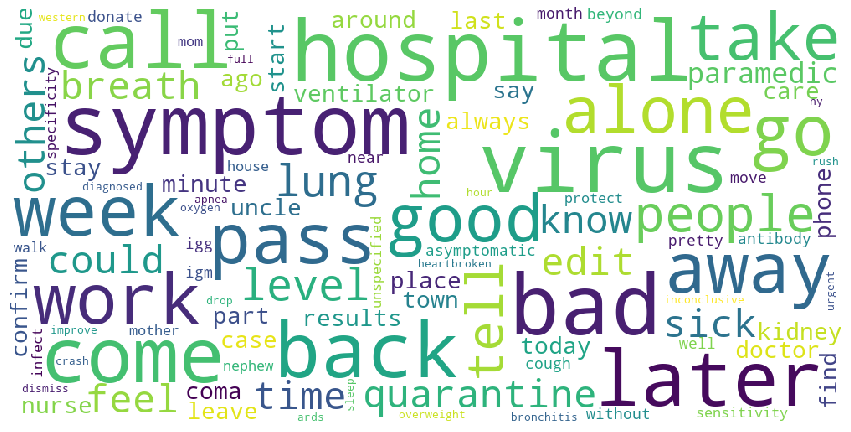

In [184]:
#Display Word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=100, 
                          random_state=42,
                          width=1000,
                          height=500,
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

[Text(0, 0, 'symptom'),
 Text(0, 0, 'go'),
 Text(0, 0, 'feel'),
 Text(0, 0, 'fever'),
 Text(0, 0, 'week'),
 Text(0, 0, 'back'),
 Text(0, 0, 'cough'),
 Text(0, 0, 'take'),
 Text(0, 0, 'bad'),
 Text(0, 0, 'know'),
 Text(0, 0, 'come'),
 Text(0, 0, 'time'),
 Text(0, 0, 'well'),
 Text(0, 0, 'start'),
 Text(0, 0, 'last'),
 Text(0, 0, 'say'),
 Text(0, 0, 'work'),
 Text(0, 0, 'good'),
 Text(0, 0, 'even'),
 Text(0, 0, 'think')]

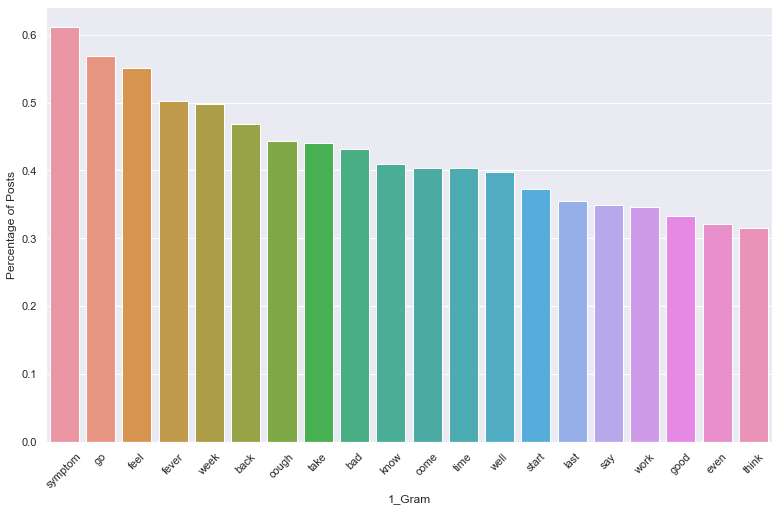

In [203]:
onegram_freq = {}
for doc in data["text"]:
    cur_onegrams = set()
    word_list = doc.split(" ")
    onegrams = [word for word in word_list if word not in stop_words]  
    for onegram in onegrams:
        if onegram not in cur_onegrams: # Add bigram, but only once/doc
            cur_onegrams.add(onegram)
    for onegram in cur_onegrams:
        if onegram in onegram_freq:
            onegram_freq[onegram] += 1
        else:
            onegram_freq[onegram] = 1

row_list = []
for onegram, freq in onegram_freq.items():
    row_list.append([onegram, freq])

result_df = pd.DataFrame(row_list) 
result_df.rename(columns={0:'1_Gram',1:'Percentage of Posts'},inplace=True)
result_df = result_df.nlargest(20,'Percentage of Posts')
result_df['Percentage of Posts']= result_df['Percentage of Posts'].transform(func = lambda x : x / data.shape[0]) 

import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="1_Gram", y="Percentage of Posts", data=result_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)



[Text(0, 0, 'come back'),
 Text(0, 0, 'shortness breath'),
 Text(0, 0, 'body ache'),
 Text(0, 0, 'sore throat'),
 Text(0, 0, 'taste smell'),
 Text(0, 0, 'smell taste'),
 Text(0, 0, 'go away'),
 Text(0, 0, 'week ago'),
 Text(0, 0, 'low grade'),
 Text(0, 0, 'grade fever'),
 Text(0, 0, 'sense smell'),
 Text(0, 0, 'start feel'),
 Text(0, 0, 'anyone else'),
 Text(0, 0, 'dry cough'),
 Text(0, 0, 'last week'),
 Text(0, 0, 'go hospital'),
 Text(0, 0, 'even though'),
 Text(0, 0, 'feel well'),
 Text(0, 0, 'stay home'),
 Text(0, 0, 'last night')]

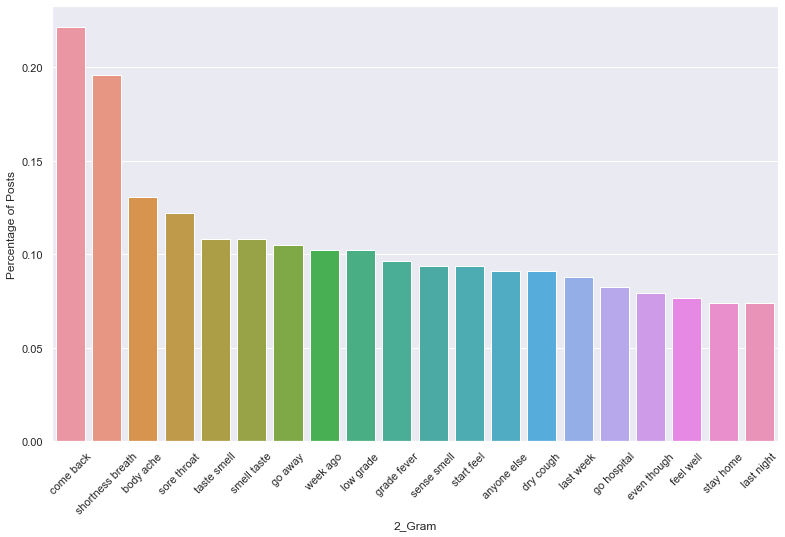

In [205]:
bigram_freq = {}
for doc in data["text"]:
    cur_bigrams = set()
    word_list = doc.split(" ")
    filtered_words = [word for word in word_list if word not in stop_words]  
    bigrams = zip(filtered_words, filtered_words[1:])
    for bigram in bigrams:
        if bigram not in cur_bigrams: # Add bigram, but only once/doc
            cur_bigrams.add(bigram)
    for bigram in cur_bigrams:
        if bigram in bigram_freq:
            bigram_freq[bigram] += 1
        else:
            bigram_freq[bigram] = 1

row_list = []
for bigram, freq in bigram_freq.items():
    row_list.append([bigram[0] + " " + bigram[1], freq])


result_df = pd.DataFrame(row_list) 
result_df.rename(columns={0:'2_Gram',1:'Percentage of Posts'},inplace=True)
result_df = result_df.nlargest(20,'Percentage of Posts')
result_df['Percentage of Posts']= result_df['Percentage of Posts'].transform(func = lambda x : x / data.shape[0]) 

import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="2_Gram", y="Percentage of Posts", data=result_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)




[Text(0, 0, 'low grade fever'),
 Text(0, 0, 'lose sense smell'),
 Text(0, 0, 'chest x ray'),
 Text(0, 0, 'sense smell taste'),
 Text(0, 0, 'loss smell taste'),
 Text(0, 0, 'sense taste smell'),
 Text(0, 0, 'loss taste smell'),
 Text(0, 0, 'come back negative'),
 Text(0, 0, 'take deep breath'),
 Text(0, 0, 'anyone else experience'),
 Text(0, 0, 'fever sore throat'),
 Text(0, 0, 'stay safe everyone'),
 Text(0, 0, 'fever body ache'),
 Text(0, 0, 'lose sense taste'),
 Text(0, 0, 'bad body ache'),
 Text(0, 0, 'go urgent care'),
 Text(0, 0, 'fever come back'),
 Text(0, 0, 'feel pretty good'),
 Text(0, 0, 'symptom come back'),
 Text(0, 0, 'fever go away')]

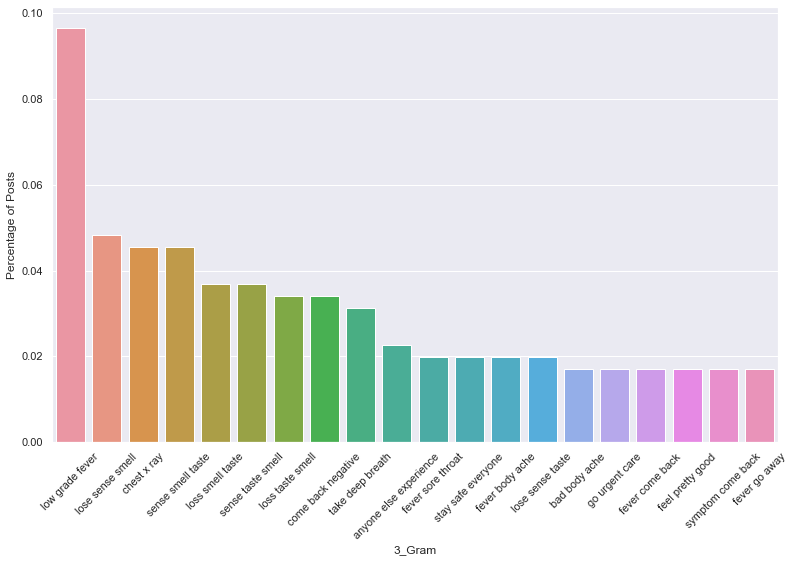

In [206]:
trigram_freq = {}
for doc in data["text"]:
    cur_trigrams = set()
    word_list = doc.split(" ")
    filtered_words = [word for word in word_list if word not in stop_words]  
    trigrams = zip(filtered_words, filtered_words[1:], filtered_words[2:])
    for trigram in trigrams:
        if trigram not in cur_trigrams: # Add trigram, but only once/doc
            cur_trigrams.add(trigram)
    for trigram in cur_trigrams:
        if trigram in trigram_freq:
            trigram_freq[trigram] += 1
        else:
            trigram_freq[trigram] = 1

row_list = []
for trigram, freq in trigram_freq.items():
    row_list.append([trigram[0] + " " + trigram[1] + " " + trigram[2], freq])


result_df = pd.DataFrame(row_list) 
result_df.rename(columns={0:'3_Gram',1:'Percentage of Posts'},inplace=True)
result_df = result_df.nlargest(20,'Percentage of Posts')
result_df['Percentage of Posts']= result_df['Percentage of Posts'].transform(func = lambda x : x / data.shape[0]) 


import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="3_Gram", y="Percentage of Posts", data=result_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)


## Results
By looking at the charts above, we can start to see what symptoms are most commonly posted by those who have tested positive for COVID-19. The major symptoms listed by the CDC that are used to determine whether someone is infected are fever, dry cough and shortness of breath.<sup>1</sup> Both "fever" and "cough" show up in approximately half of our posts, supporting that these are common symptoms, but that they may not not be present in everybody who tests positive.

When we look at the bigrams and trigrams, a few other interesting symptoms emerge. Low grade fever and loss of smell and taste show up most frequently in these charts. It's interesting that many who do have a fever have a low grade one which may not necessarily be caught by temperature screening that is being instituted in some places in order to catch asympomatic or presymptomatic cases. 

Loss of sense of smell is another symptoms that was not widely recognized until more recently,<sup>2</sup> however it shows as one of the most commonly posted symptoms in our dataset. 

Some other symptoms that appear are shortness of breath, sore throat and body aches. 

For a disease that is still so new, it's important to look at all sources of data that are available in order to gain a more complete picture of the virus. By better understanding the most frequent symptoms among those who have tested positive, we can better allocate resources and ensure we are adequately testing those who are showing early symptoms.

(1) CDC: Symptoms of Coronavirus (COVID-19) https://www.cdc.gov/coronavirus/2019-ncov/downloads/COVID19-symptoms.pdf
(2) Medical News Today: New study pinpoints loss of smell and taste as COVID-19 symptoms https://www.medicalnewstoday.com/articles/new-study-pinpoints-loss-of-smell-and-taste-as-covid-19-symptoms
